In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-krylov-structure)=
# Sparsity and structure

```{index} ! sparse matrix
```

Very large matrices cannot be stored all within primary memory of a computer unless they are **sparse**. A sparse matrix has *structural zeros*, meaning entries that are known to be exactly zero.} For instance, the adjacency matrix of a graph has zeros where there are no links in the graph. To store and operate with a sparse matrix efficiently, it is not represented as an array of all of its values. There is a variety of sparse formats available; for the most part, you can imagine that the matrix is stored as triples $(i,j,A_{ij})$ for all the nonzero $(i,j)$ locations.

## Computing with sparse matrices

```{index} adjacency matrix
```

Most graphs with real applications have many fewer edges than the maximum possible $n^2$ for $n$ nodes. Accordingly, their adjacency matrices have mostly zero elements and should be represented sparsely. Julia functions to deal with sparse matrices are found in the `SparseArrays` package in the standard library.

(demo-structure-sparse)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here we load the adjacency matrix of a graph with 2790 nodes. Each node is a web page referring to Roswell, NM, and the edges represent links between web pages. (Credit goes to Panayiotis Tsaparas and the University of Toronto for making this data public.)

In [2]:
@load "roswell.jld2" A;      # file is on the book's website

```{index} ! Julia; nnz
```
::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
We may define the density of $\mathbf{A}$ as the number of nonzeros divided by the total number of entries.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
Use `nnz` to count the number of nonzeros in a sparse matrix.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [3]:
m,n = size(A)
@show density = nnz(A) / (m*n);

density = nnz(A) / (m * n) = 0.0010902994565845762


```{index} ! Julia; summarysize
```

The computer memory consumed by any variable can be discovered using `summarysize`. We can use it to compare the space needed for the sparse representation to its dense counterpart, that is, the space needed to store all the elements, whether zero or not.

In [4]:
F = Matrix(A)
Base.summarysize(F) / Base.summarysize(A)

550.268980630567

As you can see, the storage savings are dramatic. Matrix-vector products are also much faster using the sparse form because operations with structural zeros are skipped.

In [5]:
x = randn(n)
A*x;   # make sure * is loaded and compiled
@elapsed for i in 1:300; A*x; end

0.003042209

In [6]:
F*x;
@elapsed for i in 1:300; F*x; end

0.650395333

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

```{index} fill-in of sparse matrices
```

Arithmetic operations such as `+`, `-`, `*`, and `^` respect and exploit sparsity if the matrix operands are sparse. However, matrix operations may substantially decrease the amount of sparsity, a phenomenon known as **fill-in**.

(demo-structure-fill)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here is the adjacency matrix of a graph representing a small-world network, featuring connections to neighbors and a small number of distant contacts.

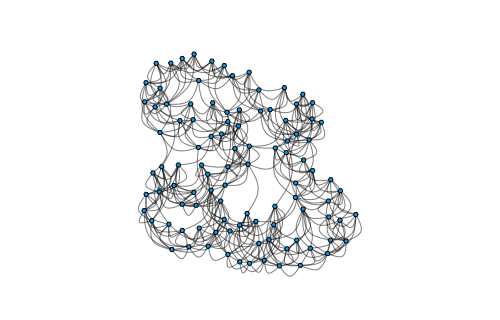

In [7]:
@load "smallworld.jld2" A
graphplot(A,linealpha=0.5)

Because each node connects to relatively few others, the adjacency matrix is quite sparse.

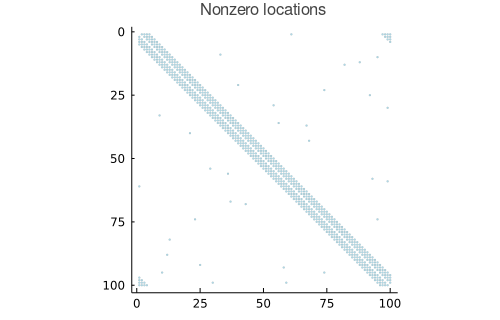

In [8]:
spy(A,title="Nonzero locations",m=2,color=:blues)

By {numref}`Theorem {number} <theorem-insight-adjmat>`, the entries of $\mathbf{A}^k$ give the number of walks of length $k$ between pairs of nodes, as with "*k* degrees of separation" within a social network. As $k$ grows, the density of $\mathbf{A}^k$ also grows.

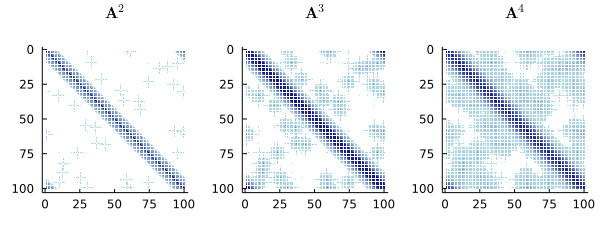

In [9]:
plt = plot(layout=(1,3),legend=:none,size=(600,240))
for k in 2:4
    spy!(A^k,subplot=k-1,color=:blues,
        title=latexstring("\\mathbf{A}^$k"))
end
plt

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Banded matrices

```{index} banded matrix
```

A particularly important type of sparse matrix is a banded matrix. Recall from {numref}`section-linsys-structure` that $\mathbf{A}$ has **upper bandwidth** $p$ if $j-i > p$ implies $A_{ij}=0$, and **lower bandwidth** $q$ if $i-j > q$ implies $A_{ij}=0$. We say the total **bandwidth** is $p+q+1$. Banded matrices appear naturally in many applications where each element interacts directly with only a few neighbors. 

```{index} LU factorization
```

Without pivoting, an LU factorization preserves bandwidth, but pivoting can change or destroy bandedness.

(demo-structure-banded)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

```{index} ! Julia; spdiagm
```

The `spdiagm` function creates a sparse matrix given its diagonal elements. The main or central diagonal is numbered zero, above and to the right of that is positive, and below and to the left is negative.

In [10]:
n = 50;
A = spdiagm(-3=>fill(n,n-3),
             0=>ones(n),
             1=>-(1:n-1),
             5=>fill(0.1,n-5) )
Matrix(A[1:7,1:7])

7×7 Matrix{Float64}:
  1.0  -1.0   0.0   0.0   0.0   0.1   0.0
  0.0   1.0  -2.0   0.0   0.0   0.0   0.1
  0.0   0.0   1.0  -3.0   0.0   0.0   0.0
 50.0   0.0   0.0   1.0  -4.0   0.0   0.0
  0.0  50.0   0.0   0.0   1.0  -5.0   0.0
  0.0   0.0  50.0   0.0   0.0   1.0  -6.0
  0.0   0.0   0.0  50.0   0.0   0.0   1.0

```{index} ! Julia; sparse
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
Without pivoting, the LU factors have the same lower and upper bandwidth as the orignal matrix.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The `sparse` function converts any matrix to sparse form. But it's usually better to construct a sparse matrix directly, as the standard form might not fit in memory.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

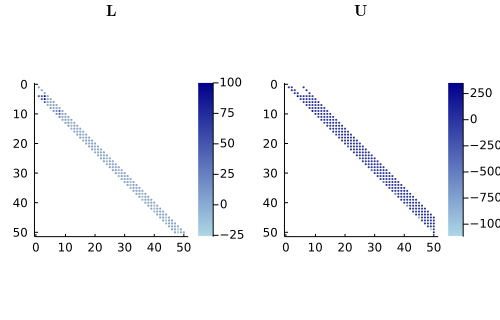

In [11]:
L,U = FNC.lufact(A)
plot(layout=2)
spy!(sparse(L),m=2,subplot=1,title=L"\mathbf{L}",color=:blues)
spy!(sparse(U),m=2,subplot=2,title=L"\mathbf{U}",color=:blues)

However, if we introduce row pivoting, bandedness may be expanded or destroyed.

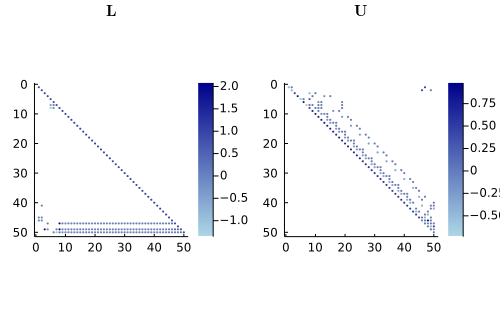

In [12]:
fact = lu(A)
plot(layout=2)
spy!(sparse(fact.L),m=2,subplot=1,title=L"\mathbf{L}",color=:blues)
spy!(sparse(fact.U),m=2,subplot=2,title=L"\mathbf{U}",color=:blues)

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Systems and eigenvalues

If given a sparse matrix, the backslash operator will automatically try a form of sparse-aware Cholesky or pivoted LU factorization. Depending on the sparsity pattern of the matrix, the time taken to solve the linear system may be well below the $O(n^3)$ needed in the general case.

```{index} eigenvalue decomposition
```

For very large matrices, it's unlikely that you will want to find all of its eigenvalues and eigenvectors. In {numref}`section-krylov-subspace` we describe some of the math behind an algorithm that can find a selected number of eigenvalues of largest magnitude, lying to the extreme left or right, or nearest a given complex number. 

(demo-structure-linalg)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The following generates a random sparse matrix with prescribed eigenvalues.

In [13]:
n = 4000
density = 4e-4
λ = @. 1 + 1/(1:n)   # exact eigenvalues
A = FNC.sprandsym(n,density,λ);

```{index} ! Julia; eigs
```

The `eigs` function finds a small number eigenvalues meeting some criterion. First, we ask for the 5 of largest (complex) magnitude using `which=:LM`.

In [14]:
λmax,V = eigs(A,nev=5,which=:LM)    # Largest Magnitude
fmt = ft_printf("%20.15f")
pretty_table([λmax λ[1:5]],["found","exact"],formatters=fmt)

┌──────────────────────┬──────────────────────┐
│                found │                exact │
├──────────────────────┼──────────────────────┤
│    2.000000000000002 │    2.000000000000000 │
│    1.500000000000002 │    1.500000000000000 │
│    1.333333333333331 │    1.333333333333333 │
│    1.250000000000004 │    1.250000000000000 │
│    1.200000000000000 │    1.200000000000000 │
└──────────────────────┴──────────────────────┘


Now we find the 5 closest to the value 1 in the complex plane, via `sigma=1`.

In [15]:
λ1,V = eigs(A,nev=5,sigma=1)    # closest to sigma
data = [λ1 λ[end:-1:end-4]]
pretty_table(data,["found","exact"],formatters=fmt)

┌──────────────────────┬──────────────────────┐
│                found │                exact │
├──────────────────────┼──────────────────────┤
│    1.000250000000000 │    1.000250000000000 │
│    1.000250062515629 │    1.000250062515629 │
│    1.000250125062531 │    1.000250125062531 │
│    1.000250187640731 │    1.000250187640731 │
│    1.000250250250250 │    1.000250250250250 │
└──────────────────────┴──────────────────────┘


```{index} Julia; \\
```

The time needed to solve a sparse linear system is not easy to predict unless you have some more information about the matrix. But it will typically be orders of magnitude faster than the dense version of the same problem.

In [16]:
x = @. 1/(1:n);  b = A*x;

In [17]:
norm(x-A\b);  # force compilation
t = @elapsed sparse_err = norm(x - A\b)
println("Time for sparse solve: $t")

Time for sparse solve: 0.002951709


In [18]:
D = Matrix(A)  # convert to regular matrix
norm(x-D\b);
t = @elapsed dense_err = norm(x - D\b)
println("Time for dense solve: $t")

Time for dense solve: 1.382613208


In [19]:
@show sparse_err;
@show dense_err;

sparse_err = 1.1304836770089884e-16
dense_err = 8.343779295226473e-18


```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

1. ⌨ Use `spdiagm` to build the $50\times 50$ matrices
  
    :::{math}
    \mathbf{A} =
    \begin{bmatrix}
    -2 & 1 & & &  \\
    1 & -2 & 1 & &  \\
    & \ddots & \ddots & \ddots & \\
    & & 1 & -2 & 1 \\
    & & & 1 & -2
    \end{bmatrix}, \qquad
    \mathbf{B} =
    \begin{bmatrix}
    -2 & 1 & & & 1 \\
    1 & -2 & 1 & &  \\
    & \ddots & \ddots & \ddots & \\
    & & 1 & -2 & 1 \\
    1 & & & 1 & -2
    \end{bmatrix}.
    :::

    For each matrix, use `spy` and an inspection of the $5\times 5$ submatrices in the corners to verify the correctness of your matrices.

2. ⌨ This problem requires the matrix used in {numref}`Demo %s <demo-structure-fill>`; you can load it via

    ```julia
    url = "https://tobydriscoll.net/fnc-julia/_static/resources/smallworld.jld2"
    datafile = download(url)
    @load datafile A
    ```
    **(a)** Find the density of $\mathbf{A}$ (number of nonzeros divided by total number of elements), $\mathbf{A}^2$, $\mathbf{A}^4$, and $\mathbf{A}^8$. (You should find that it increases with the power of $A$.)

    **(b)** The LU factors tend to at least partially retain sparsity. Find the density of the $\mathbf{L}$ and $\mathbf{U}$ factors of $\mathbf{A}$ using the built-in `lu`. (See {numref}`Demo {number} <demo-structure-banded>` for usage of `lu` in the sparse case.)

    **(c)** Repeat part (b) for the QR factorization using `qr`.

    (problem-structure-roswell)=
3. ⌨ One use of adjacency matrices is to analyze the links between members of a collection. Obtain the adjacency matrix $\mathbf{A}$ from {numref}`Demo %s <demo-structure-sparse>` via the following:
    
    ```julia
    url = "https://tobydriscoll.net/fnc-julia/_static/resources/roswell.jld2"
    datafile = download(url)
    @load datafile A
    ```
    
    The matrix catalogs the links between web sites related to the town of Roswell, NM, with $A_{ij}=1$ if and only if site $i$ links to site $j$.
  
    **(a)** Verify numerically that the matrix does not include any links from a site to itself.

    **(b)** Verify numerically that $\mathbf{A}$ is not symmetric. (Thus, its graph is a directed one.)

    **(c)** How many sites in the group are not pointed to by any other sites in the group?

    **(d)** Which site points to the most other sites?

    **(e)** Which site is pointed to the most by the other sites? This is a crude way to establish the most important site.

    **(f)** There are $2790^2$ possible ways to connect ordered pairs of sites. What fraction of these pairs is connected by a walk of links that is no greater than three in length?

 
    ```{index} ! graph Laplacian matrix, ! degree matrix
    ```

4. ⌨ The *graph Laplacian matrix* is $\mathbf{L}=\mathbf{D}-\mathbf{A}$, where $\mathbf{A}$ is the adjacency matrix and $\mathbf{D}$ is the *degree matrix*, a diagonal matrix with diagonal entries $d_{jj}=\sum_{i=1}^n a_{ij}$. 
   
    Follow the directions in Exercise 3 to obtain an adjacency matrix $\mathbf{A}$. Then find the five eigenvalues of $\mathbf{L}$ having largest magnitude.

    (problem-structure-actorsmat)=
5. ⌨ See [Exercise 7.1.5](problem-insight-actors) for instructions on loading a matrix $\mathbf{A}$ that contains information about the appearances of 392,400 actors in 127,823 movies, as given by the Internet Movie Database. Specifically, $A_{ij}=1$ if actor $j$ appeared in movie $i$, and all other elements are zero.

    **(a)** What is the maximum number of actors appearing in any one movie?

    **(b)** How many actors appeared in exactly three movies?

    **(c)** Define $\mathbf{C}=\mathbf{A}^T\mathbf{A}$. How many nonzero entries does $\mathbf{C}$ have? What is the interpretation of $C_{ij}$?

    ```{index} ! Helmholtz equation
    ```
    
    (problem-helmhotzmatrix)=
6. ⌨  A matrix that arises from the *Helmholtz equation* for wave propagation can be specified using 

    ```julia
    A = FNC.poisson(n) - k^2*I;
    ```
    where $k$ is a real parameter. Let $n=50$. 
    
    **(a)** Let $k=1$. What is the size of $\mathbf{A}$? What is its density?

    **(b)** Still with $k=1$, use `eigs` to find the four largest and four smallest (in magnitude) eigenvalues of $\mathbf{A}$. (See {numref}`Demo %s <demo-structure-linalg>` for examples.)

    **(c)** The eigenvalues are all real. Find a value of $k$ so that $\mathbf{A}$ has exactly three negative eigenvalues.